<a href="https://colab.research.google.com/github/JAaron93/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/Time_Series_Forecasting_Student_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time #helper libraries
from tensorflow.keras import regularizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----
### Load Data

In [3]:
def load_transform_data():
    """
    Load energy and weather data sets for energy consumption over a 4 year period for a single household in Austin, Texas. 
    Perform transformations in order to get data into a format that we can more easily use for LSTM modeling.
    Notes
    -----
    Links to source of data:
    https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries?select=weather_2016_2020_daily.csv
    Parameters 
    ------
    None
    Returns
    -------
    df: pandas dataframe
        Contains both the energy and weather feature sets 
    """
    # load energy data
    energy_data = "/content/drive/MyDrive/Colab Notebooks/Energy_Data/energy_usage_2016_to_2020.csv"
    df_energy = pd.read_csv(energy_data)
    # load weather data
    weather_data = "/content/drive/MyDrive/Colab Notebooks/Energy_Data/weather_2016_2020_daily.csv"
    df_weather = pd.read_csv(weather_data)
    # create a datetime index 
    df_energy.index = pd.to_datetime(df_energy.StartDate)
    df_weather.index = pd.to_datetime(df_weather.Date)
    # drop redundent columns in df_energy
    drop_cols = ["StartDate", "day_of_week"]
    df_energy.drop(drop_cols, axis=1, inplace=True)
    # drop redundent columns in df_weather
    drop_cols = ["Date", "Day"]
    df_weather.drop(drop_cols, axis=1, inplace=True)
    # rename columns in energy df
    rename_cols = {"Value (kWh)": "kWh", "notes": "day_type"}
    df_energy.rename(columns=rename_cols, inplace=True)
    # resample hourly energy consumption to the daily level 
    df_energy_daily = df_energy.resample("D").sum()
    df = df_energy_daily.merge(df_weather, left_index=True, right_index=True)
    # dates don't perfectly overlap between energy and weather datasets which results in 52 daily null values -- drop them
    # this happend because some dates exist in one dataset but not the other
    nan_mask = df.isnull() == False
    df = df[nan_mask]
    # truncate series in order to drop missing values 
    df = df.loc["2016-06-01":"2020-01-01"]
    return df

In [4]:
# load energy data
energy_data = "/content/drive/MyDrive/Colab Notebooks/Energy_Data/energy_usage_2016_to_2020.csv"
df_energy = pd.read_csv(energy_data)

In [5]:
# load weather data
weather_data = "/content/drive/MyDrive/Colab Notebooks/Energy_Data/weather_2016_2020_daily.csv"
df_weather = pd.read_csv(weather_data)

In [6]:
df_weather.head()

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
0,2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
1,2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2,2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
3,2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
4,2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [7]:
df_energy.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [8]:
# Create a datetime index
df_energy.index = pd.to_datetime(df_energy.StartDate)
df_weather.index = pd.to_datetime(df_weather.Date)

In [9]:
df_energy

,StartDate,Value (kWh),day_of_week,notes
StartDate,,,,
2016-01-06 00:00:00,2016-01-06 00:00:00,1.057,2,weekday
2016-01-06 01:00:00,2016-01-06 01:00:00,1.171,2,weekday
2016-01-06 02:00:00,2016-01-06 02:00:00,0.560,2,weekday
2016-01-06 03:00:00,2016-01-06 03:00:00,0.828,2,weekday
2016-01-06 04:00:00,2016-01-06 04:00:00,0.932,2,weekday
...,...,...,...,...
2020-07-07 19:00:00,2020-07-07 19:00:00,1.307,1,weekday
2020-07-07 20:00:00,2020-07-07 20:00:00,2.872,1,weekday
2020-07-07 21:00:00,2020-07-07 21:00:00,2.138,1,weekday


In [10]:
df_weather

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
Date,,,,,,,,,,,,,,,,,,,
2016-01-06,2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-02-06,2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2016-03-06,2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
2016-04-06,2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
2016-05-06,2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,2020-08-26,26,95,83.4,79,79,75.7,73,94,78.2,54,21,12.4,8,29.7,29.7,29.6,0.01,2
2020-08-27,2020-08-27,27,99,87.1,78,75,72.0,69,82,62.7,39,14,8.0,0,29.7,29.6,29.5,0.00,3
2020-08-28,2020-08-28,28,98,86.5,79,79,77.2,74,94,75.6,49,18,8.1,0,29.8,29.7,29.7,0.00,4


In [11]:
# drop redundant columns
drop_cols = ["StartDate", "day_of_week"]
df_energy.drop(drop_cols, axis=1, inplace=True)

In [12]:
drop_cols = ["Date", "Day"]
df_weather.drop(drop_cols, axis=1, inplace=True)
df_weather

,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
Date,,,,,,,,,,,,,,,,,
2016-01-06,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-02-06,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2016-03-06,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
2016-04-06,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
2016-05-06,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,95,83.4,79,79,75.7,73,94,78.2,54,21,12.4,8,29.7,29.7,29.6,0.01,2
2020-08-27,99,87.1,78,75,72.0,69,82,62.7,39,14,8.0,0,29.7,29.6,29.5,0.00,3
2020-08-28,98,86.5,79,79,77.2,74,94,75.6,49,18,8.1,0,29.8,29.7,29.7,0.00,4


In [13]:
df_energy

,Value (kWh),notes
StartDate,,
2016-01-06 00:00:00,1.057,weekday
2016-01-06 01:00:00,1.171,weekday
2016-01-06 02:00:00,0.560,weekday
2016-01-06 03:00:00,0.828,weekday
2016-01-06 04:00:00,0.932,weekday
...,...,...
2020-07-07 19:00:00,1.307,weekday
2020-07-07 20:00:00,2.872,weekday
2020-07-07 21:00:00,2.138,weekday


In [14]:
rename_cols = {"Value (kWh)": "kWh", "notes": "day_type"}
df_energy.rename(columns=rename_cols, inplace=True)

In [15]:
df_energy.head()

,kWh,day_type
StartDate,,
2016-01-06 00:00:00,1.057,weekday
2016-01-06 01:00:00,1.171,weekday
2016-01-06 02:00:00,0.560,weekday
2016-01-06 03:00:00,0.828,weekday
2016-01-06 04:00:00,0.932,weekday


In [16]:
df_weather.head()

,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
Date,,,,,,,,,,,,,,,,,
2016-01-06,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-02-06,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2016-03-06,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
2016-04-06,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
2016-05-06,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [17]:
df_energy_daily = df_energy.resample("D").sum()
# Have to resample on a date-time based column or index

In [18]:
# merge these data sets
df_energy_daily.merge(df_weather, left_index=True, right_index=True)
# Now we can pass all this in to a function to make it reproducible!

,kWh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
2016-01-06,29.691,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-01-07,43.177,94,84.9,76,76,74.0,72,94,71.6,51,13,5.7,0,29.9,29.9,29.8,0.00,3
2016-01-08,50.057,97,86.5,75,76,73.3,67,96,67.3,37,20,6.0,0,30.0,29.9,29.9,0.00,4
2016-01-09,47.363,96,86.2,78,75,73.3,70,88,67.1,46,13,6.3,0,29.8,29.8,29.7,0.01,5
2016-01-10,42.203,81,71.1,61,64,59.4,57,90,68.7,45,8,3.3,0,30.0,29.9,29.9,0.00,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-02,12.087,57,53.9,50,55,50.6,47,97,88.8,82,17,7.7,0,29.9,29.8,29.7,0.05,2
2020-12-03,16.130,84,74.1,69,66,63.2,61,84,69.8,46,16,9.0,5,29.9,29.8,29.7,0.00,3
2020-12-04,18.011,89,79.5,69,74,64.0,47,88,63.0,28,18,11.8,0,29.7,29.5,29.4,0.00,4
2020-12-05,15.777,83,75.2,67,70,65.4,61,87,72.2,54,24,13.4,0,29.9,29.9,29.8,0.00,5


In [19]:
df = load_transform_data()

In [20]:
df.head()

,kWh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
2016-06-06,29.323,87,76.6,70,73,70.8,68,100,84.0,53,8,4.7,0,29.7,29.7,29.6,0.44,0
2016-06-07,43.361,95,87.0,82,79,74.4,69,89,67.6,44,15,9.9,6,29.9,29.9,29.8,0.00,1
2016-06-08,55.993,97,87.6,78,76,72.8,65,90,64.1,36,16,5.8,0,29.9,29.8,29.8,0.00,2
2016-06-09,39.040,92,83.2,75,76,73.8,70,97,75.0,48,16,7.0,0,30.0,30.0,29.9,0.02,3
2016-06-10,33.993,89,80.2,74,75,73.2,69,97,80.7,55,16,8.1,0,29.8,29.8,29.8,0.00,4


----
### Explore data with some plots

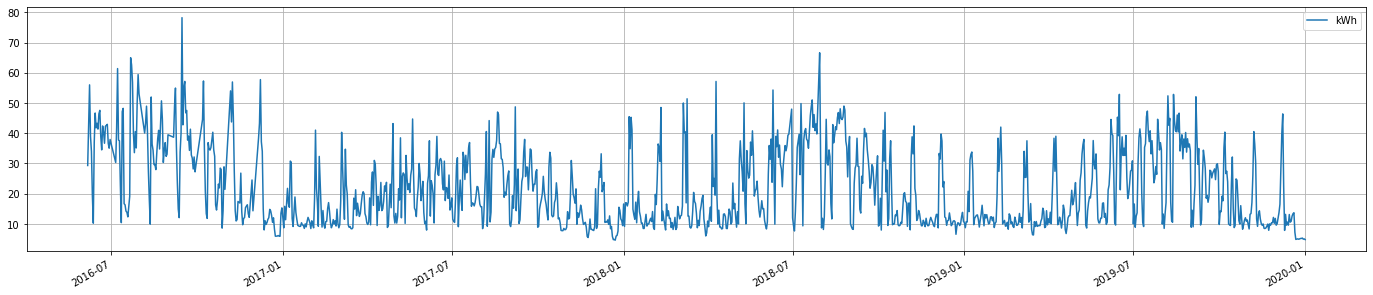

In [21]:
# Checking the power usage/energy consumption over the years. We can see the seasonality of the year is correlated with higher or lower
# energy consumption. Doesn't seem to be any extreme outliers either
df.kWh.plot(figsize=(24,5), grid=True, legend=True);

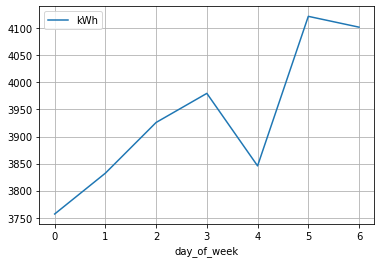

In [22]:
# index 0 is Monday
# index 6 is Sunday
df.groupby(["day_of_week"])[["kWh"]].sum().plot(grid=True);

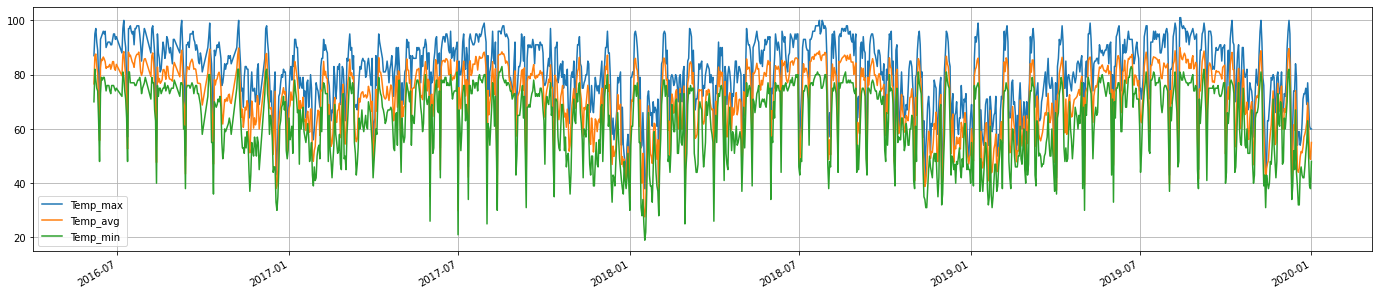

In [23]:
plot_cols = ["Temp_max", "Temp_avg", "Temp_min"]
df[plot_cols].plot(figsize=(24,5), grid=True, legend=True);

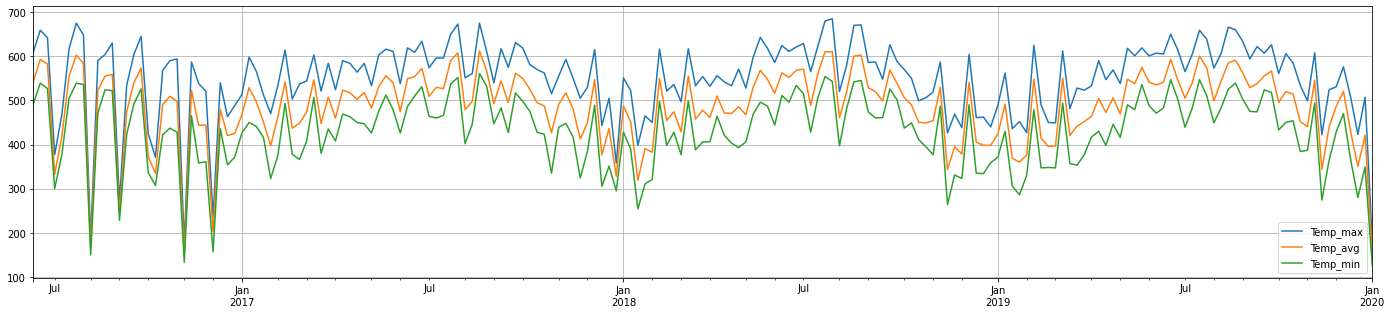

In [24]:
df[plot_cols].resample("W").sum().plot(figsize=(24,5), grid=True, legend=True);
# Plotting at weekly level

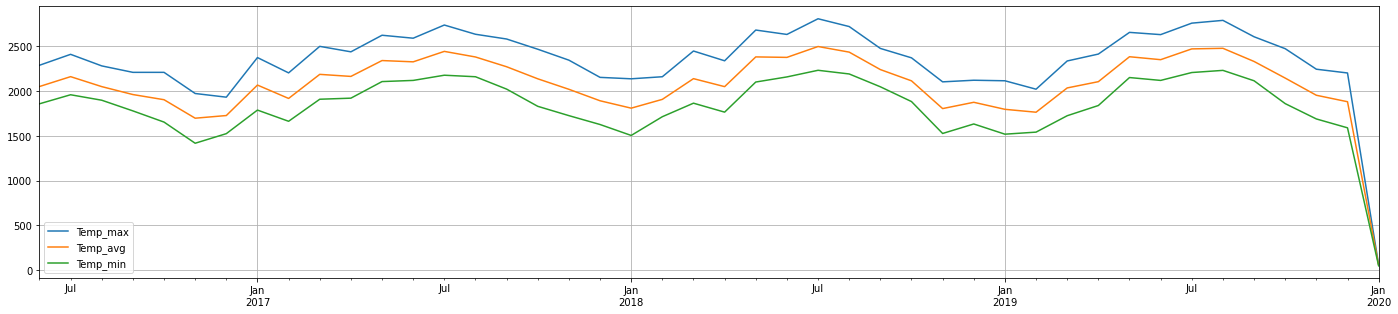

In [25]:
df[plot_cols].resample("M").sum().plot(figsize=(24,5), grid=True, legend=True);
# Plotting at the monthly level

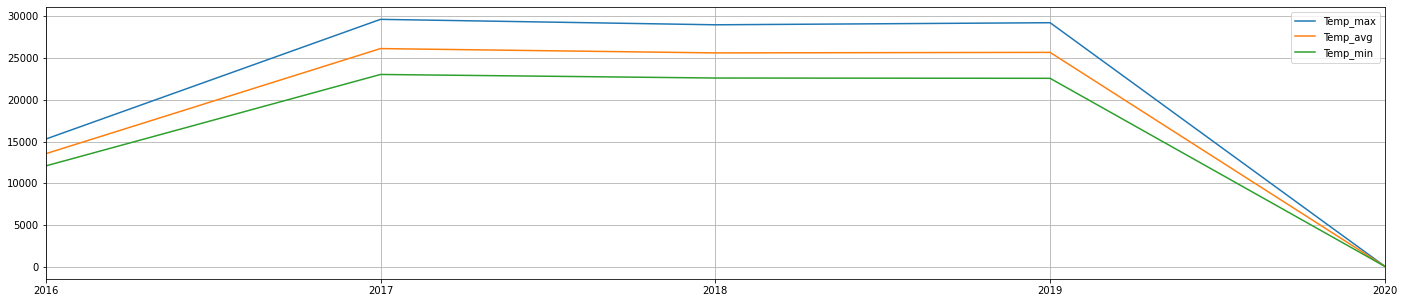

In [26]:
df[plot_cols].resample("A").sum().plot(figsize=(24,5), grid=True, legend=True);
# Plotting at the annual level

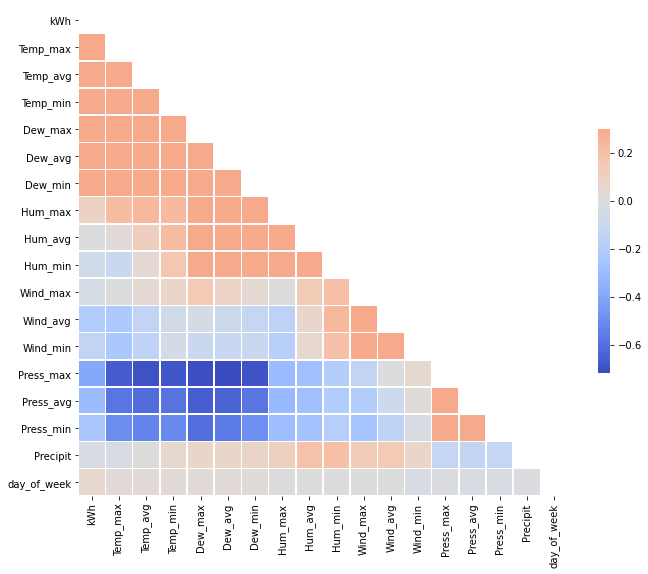

In [27]:
# plot the feature correlations 

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [28]:
# Create correlation threshold to filter out features with low correlations with kWh column
corr_thresh = 0.10
# Create correaltion mask
corr_mask = corr.kWh.abs()>= corr_thresh
# save surviving features to variable
keep_feats = corr.kWh[corr_mask].index
# Mask column in dataframe
df = df[keep_feats]
### We then turn this code cell into this function below to make it reproducible!!  ###

In [29]:
def select_high_corr_features(df, corr_thresh = 0.10):
  '''
  Feature Selection algorithm based on correlation threshold
  Features with a correlation to kWh greater than corr_thresh will be dropped
  '''
  # Create correlation threshold to filter out features with low correlations with kWh column
  corr_thresh = 0.10
  # Create correaltion mask
  corr_mask = corr.kWh.abs()>= corr_thresh
  # save surviving features to variable
  keep_feats = corr.kWh[corr_mask].index
  # Mask column in dataframe
  return df[keep_feats]

In [30]:
df

,kWh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min
2016-06-06,29.323,87,76.6,70,73,70.8,68,100,4.7,0,29.7,29.7,29.6
2016-06-07,43.361,95,87.0,82,79,74.4,69,89,9.9,6,29.9,29.9,29.8
2016-06-08,55.993,97,87.6,78,76,72.8,65,90,5.8,0,29.9,29.8,29.8
2016-06-09,39.040,92,83.2,75,76,73.8,70,97,7.0,0,30.0,30.0,29.9
2016-06-10,33.993,89,80.2,74,75,73.2,69,97,8.1,0,29.8,29.8,29.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,5.200,77,69.6,63,68,65.0,61,97,10.1,3,29.8,29.7,29.6
2019-12-29,5.309,69,60.8,50,66,51.8,36,97,9.9,3,29.9,29.7,29.6
2019-12-30,4.947,61,50.3,39,37,31.0,26,89,5.7,0,30.1,30.0,29.9
2019-12-31,5.042,60,48.8,38,39,31.3,22,77,2.7,0,30.2,30.1,30.0


----
### Feature Selection

In [47]:
# Select which features you want to input into the model 
input_cols = []
df = df[input_cols]

----
### Scale Data

In [32]:
def scale_data(df):
    """
    Scale time series features, save the scaler function for each feature in a look up dict for inverse scaling post model training. 
    
    Parameters
    ----------
    df: pandas dataframe
    
    Returns
    -------
    df: pandas datafarme 
        Contains scaled features
        
    scaler_dict: dict 
        look up for feature scaler objects 
        key: column name
        value: column scaler 
    """
    
    # use to save the column scaler functions
    scaler_dict = {} 
    
    # use to save the scaled column data
    scaled_data = {} 
    
    for col in df.columns:
        
        # instantiate the scaler class 
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # reshape to avoid shape errors
        feat = df[col].values.reshape(-1, 1)
        
        # scale data
        # DATA LEAKAGE! Scaler should only be fitted to training data
        # train test split should have been done prior to scaling
        col_scaled = scaler.fit_transform(feat)
        
        # save scaled column data to column key
        scaled_data[col] = col_scaled.flatten()
        
        # save scaler function to column key 
        scaler_dict[col] = scaler
        
    # move scaled data from dict to dataframe
    df_scaled = pd.DataFrame.from_dict(scaled_data)
    
    return df_scaled, scaler_dict

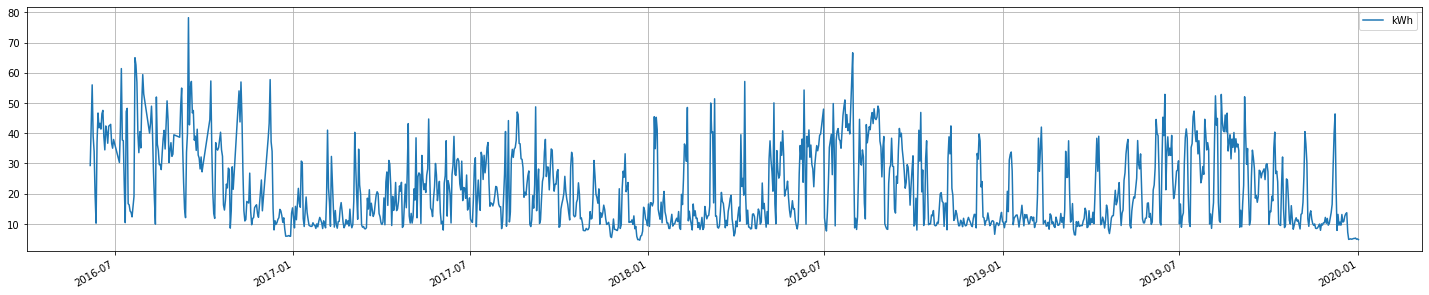

In [33]:
# plot non-scaled data
df.kWh.plot(figsize=(25,5), grid=True, legend=True);

In [34]:
# scale data 
df_scaled, scaler_dict = scale_data(df)

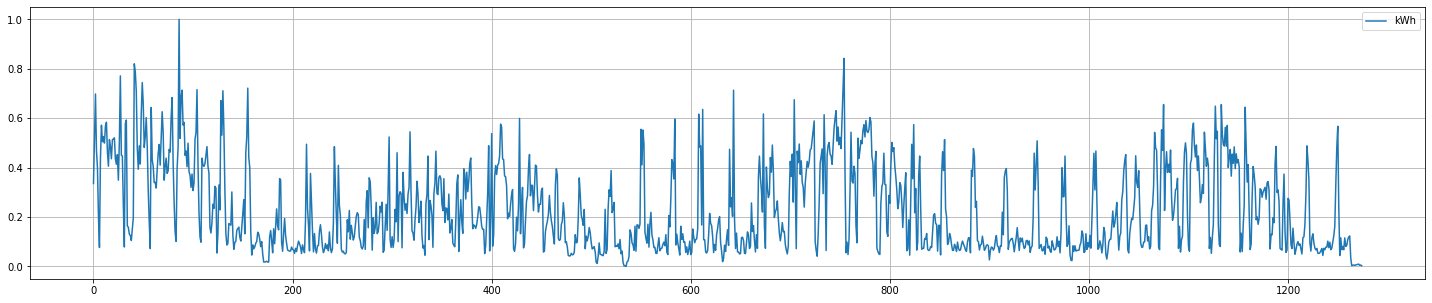

In [35]:
# plot scaled data
df_scaled.kWh.plot(figsize=(25,5), grid=True, legend=True);

----
### Create Samples

In [36]:
def create_dataset(data, look_back=1, look_ahead=1):
    """
    Takes a 2D array of sequential data and creates (X) input and (Y) output sequences for timeseries forecasting.
    
    Paramters
    ---------
    data: 2D numpy array
        contains sequential data with n rows and m columns
        
        If you provide more than a single input feature, make sure that the feature that is also used for the output
        is positioned in the 0 (zero) index column of the the array. Code below assumes this to be the case! 
        
        Example
        -------
        For the example data below, kWh column will be used as the output feature (i.e. what the model will be predicting).
        
                    kWh     Temp_avg
            0	0.335705	0.785256
            1	0.526399	0.951923
            2	0.697993	0.961538
            3	0.467702	0.891026
            4	0.399143	0.842949      
        
    look_back: int or float
        length of input sequence 
        
        I.E if look_behind = 1, then the input is a single value with index [t] (the present timestep)
            if look_behind = 2, then the input is a sequence of vlaues with indices [t - 1, t]
            if look_behind = n, then the input is a sequence of values with indices [t - n, t - (n - 1), ... , t - 1, t]
            
    look_ahead: int or float
        number of steps into the future that we want to forecast
        
        I.E. if look_ahead = 1, then we want to forecast the value 1 timestep from now,  t + 1
             if look_ahead = 2, then we want to forecast the value 2 timesteps from now, t + 2
             if look_ahead = b, then we want to forecast the value n timesteps from now, t + n
    """
    # use to store new sequence samples 
    X_data, Y_data = [], []
    
    # number of original samples in dataset
    n_samples = len(data)
    
    # avoid an index error in the for loop by capping the max index value 
    # since we are using look_back & look_ahead number of samples for input and output sequences, respectively
    truncate = look_back + look_ahead 
    
    # number of new samples to create
    # we must subtract truncate from the number of new samples because the size of the look_back & look_ahead windows 
    n_new_samples = n_samples - (truncate + 1)
    
    # if user provided data with more than a single input feature
    # then index for the feature in the 0 index and use that as the output feature
    if data.shape[1] > 1:
        y_data = data[:, 0]
        
    # if user provided a single feature dataset, leave data set as is 
    else:
        y_data = data
        
    # LOGIC FOR CREATING X AND Y 
    # we are going to create n_new_samples number of samples for our model 
    for i in range(n_new_samples):
        
        # create input sequence sample 
        x = data[i : i+look_back]
        
        # create output sequence sample 
        y = y_data[i+look_back : i + look_back + look_ahead ]
        y = y[-1] # y is actually a sequnce, so we need to take the last value as our output (i.e. we are predicting a single value, not multiple)
        
        # append new samples to lists
        X_data.append(x)
        Y_data.append(y)
        
    return np.array(X_data), np.array(Y_data)

![](https://i.stack.imgur.com/fXZ6k.png )

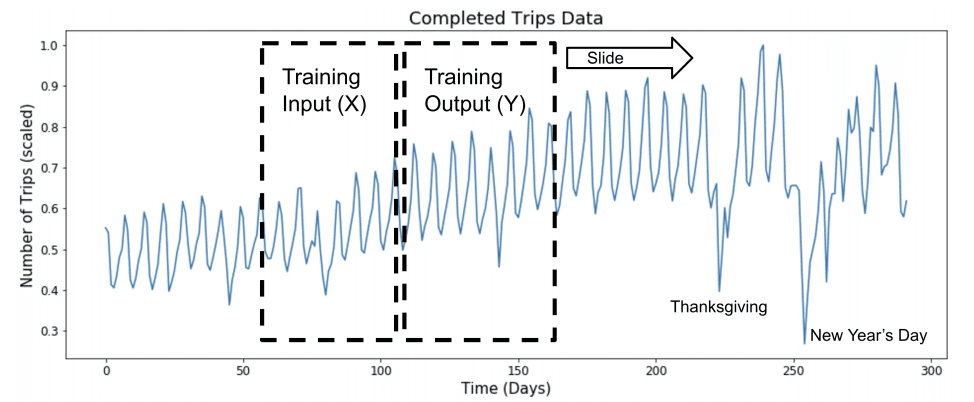

# Personal Note
We have to perserve the sequential order of the data as we go about creating input and output data. We can NOT shuffle it. We need to generate a window and *slide* it across the data in order to create the training input/output sequences!

Let's create a small and simple dummy data set as input for `create_data` in order to see how the input and output data are structured. 

In [37]:
# create dummy array to test how function works
# note: the values here are completely arbitrary
# but using small, sequential integers helps us understanding the structuring of the sequences 
n = 11
dummy_data = np.arange(1, n)
dummy_data =dummy_data.reshape((dummy_data.shape[0], 1))
dummy_data


array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [38]:
X_data, Y_data = create_dataset(dummy_data, 
                                look_back=2, 
                                look_ahead=2
                               )
# We can change the look_back and look_ahead to whatever value
# if we have both set to 2, the sequence of values will come as pairs, if not, they some individually. If it's set as 3,
# it comes in groups of 3, etc.

In [39]:
X_data
# We can think of each number in the array is Day 1, Day 2, Day 3, etc. The sequence is perserved. 

array([[[1],
        [2]],

       [[2],
        [3]],

       [[3],
        [4]],

       [[4],
        [5]],

       [[5],
        [6]]])

In [40]:
Y_data

array([[4],
       [5],
       [6],
       [7],
       [8]])

In [41]:
def create_train_test_split(df, look_back = 1, look_ahead = 1, train_size = 0.60):
    """
    Creates a train test split for sequential data used for time series forecasting. 
    """
    
    # calculate the number of training samples 
    n_samples = df.shape[0]
    train_size = int(n_samples * train_size)

    # samples between the zero and train_size indices are training samples 
    train = df.iloc[:train_size].values
    
    # samples between the train_size and the nth index are test samples 
    test = df.iloc[train_size:].values

    # create input and output splits 
    X_train, Y_train = create_dataset(train, look_back=look_back, look_ahead=look_ahead)
    X_test, Y_test = create_dataset(test, look_back=look_back, look_ahead=look_ahead)
    
    return X_train, Y_train, X_test, Y_test

In [42]:
# split data into X and Y train/test sets 
# Looking back 7 days (one week) for our model, and then asking it to predict the next day
# Predicting just one day from now will have less error than three weeks
look_back = 7
look_ahead = 1

X_train, Y_train, X_test, Y_test = create_train_test_split(df,
                                                           look_back = look_back,
                                                           look_ahead = look_ahead,
                                                           train_size = 0.60)

In [43]:
X_train.shape
# (number of samples, number of time steps, number of input features for model)

(756, 7, 13)

In [44]:
X_train.shape, Y_train.shape

((756, 7, 13), (756,))

In [45]:
X_test.shape, Y_test.shape

((501, 7, 13), (501,))

----
### Create and train model

In [48]:
# this model architecture is arbitrary - you can experiment with different architectures to see how it affects the score (i.e. gridsearch)
n_feats = len(input_cols)
epochs = 20
batch_size = 32
dropout_prob = 0.5

#
input_shape = (look_back, n_feats)

### Create and train model here
# create sequential instance
model = Sequential()
# add bidirectional LSTM
model.add(Bidirectional(LSTM(250,
                             input_shape=input_shape,
                             activation="relu")))

# add dropout regularization
model.add(Dropout(dropout_prob))

# add dense hidden layer
# adding learning rate into our regularization parameter
model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.L2(l2=0.001)))

# add dense output layer
# We have just one output node. This is basically a regression problem, so we only need a single float value returned.
model.add(Dense(1, activation="gelu"))

# compile computational graph - under the hood ;)
# I can more than one metric
# Considering this is a regression problem, we have different loss functions and metrics used https://keras.io/api/losses/regression_losses/
model.compile(loss="mean_square_error", optimizer="nadam", metrics=["mean_square_error", "mean_absolute_error"])

In [ ]:
# print summary
# model.summary()

In [49]:
history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(X_test,Y_test))

Epoch 1/20


ValueError: ignored

---
### Visualize model results

In [ ]:
def plot_model_loss_metrics(history):
    """
    Use the model history callback to plot the train and test losses vs epochs as well as metrics vs. epochs 
    """
    
    # plot training and test loss scores 
    # HARD CODING IS A NO-NO
    # better written code would have to flexibility to plot 
    test_loss = history.history["val_loss"]
    train_loss = history.history["loss"]
    
    test_mse = history.history["val_mean_squared_error"]
    train_mse = history.history["mean_squared_error"]
    
    test_mae = history.history["val_mean_absolute_error"]
    train_mae = history.history["mean_absolute_error"]
    
    n_epochs = len(test_loss) + 1
    epoches = np.arange(1,  n_epochs)
    y_ticks = np.arange(0, 1, 11)

    plt.figure(figsize=(20,5))
    plt.title("Loss vs. Number of Epochs")
    plt.plot(epoches, test_loss, label = "Test Loss")
    plt.plot(epoches, train_loss, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 
    
    
    plt.figure(figsize=(20,5))
    plt.title("mean_squared_error vs. Number of Epochs")
    plt.plot(epoches, test_mse, label = "Test Loss")
    plt.plot(epoches, train_mse, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 
    
    
    plt.figure(figsize=(20,5))
    plt.title("mean_absolute_error vs. Number of Epochs")
    plt.plot(epoches, test_mae, label = "Test Loss")
    plt.plot(epoches, train_mae, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 

In [ ]:
# plot model scores

In [ ]:
def predict(X_train, X_test):
    # make predictions on train and test inputs 
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    return y_train_predict, y_test_predict

In [ ]:
# get predictions 

In [ ]:
# Y_test and Y_train can be passed through this function only once
# predictions can be passed in here multiple times 
def inverse_scaling(data, scaler_dict, output_feat_name):
    """
    Now that we have trained our model on scaled data (and made predictions on the scaled test data)
    we need to invert the scaling so we have have the data in it's original formate for interpretability. 
    """
    return scaler_dict[output_feat_name].inverse_transform(data)

In [ ]:
# reshape Y_train and Y_test so number of rows appers first, i.e. (rows,cols)

In [ ]:
# perform inverse scaling of the data

----
### Plot Model Predictions

In [ ]:
def plot_predictions(Y_train, y_train_predict, Y_test, y_test_predict):
    
    
    plt.figure(figsize=(20,5))
    plt.title("Training Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_train_predict, label = "Predict", c="r")
    plt.plot(Y_train, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();
    
    plt.figure(figsize=(20,5))
    plt.title("Test Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_test_predict, label = "Predict", c="r")
    plt.plot(Y_test, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();

In [ ]:
# plot model predictions 

-----
### Compare Model against a Baseline 

One commen baseline to use is to simply shift the kWh values up by `look_ahead` amount and compare that to the true values that occur an a date. In order words, assume that the kWh consumption tomorrow will be the same as the energy consumption to today. So then we can ask the question "can the model perform better than simply assuming that tomorrow will look like today?"

Of course since `look_ahead` can be any value (not just 1) then the navie guess becomes "assume that the kWh consumption X number of days from now be the same as today."

In [ ]:
# use root mean squared error as metric for comparison 
train_score = math.sqrt(mean_squared_error(Y_train, y_train_predict))
print('Train Score: %.4f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(Y_test, y_test_predict))
print('Test Score: %.4f RMSE' % (test_score))

navie_score = math.sqrt(mean_squared_error(...?, ...?))
print('Naive baseline Score: %.4f RMSE' % (test_score))